In [1]:
import layers
import modules
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import resample_poly
from pathlib import Path
from sklearn.model_selection import train_test_split
import os

from AF_metrics_utils import *

In [2]:
FS_ECG_ORIG = 2048        # Hz
FS_TARGET   = 284         # Hz
WIN_SEC     = 2        # window length (s)
STEP_SEC    = 1       # 50 % overlap

UP, DOWN = FS_TARGET, FS_ECG_ORIG          # 71 / 512 after gcd

def load_record(rec_idx: int, env_dir, ecg_dir):
    """Load one record and return 284 Hz ECG + envelope arrays."""
    env  = sio.loadmat(env_dir / f"{rec_idx}_envelope.mat")["x_up"].squeeze()
    ecg  = sio.loadmat(ecg_dir / f"results01_{rec_idx}.mat")["fref1"].flatten()
    ecg284 = resample_poly(ecg, UP, DOWN).astype(np.float32)
    env    = env.astype(np.float32)
    # Trim for minor difference
    L = min(len(ecg284), len(env))
    return ecg284[:L], env[:L]

In [3]:
WIN = int(WIN_SEC  * FS_TARGET)      # 3.75 s × 284 Hz = 1065
STEP = int(STEP_SEC * FS_TARGET)     # 50 % overlap

X, Y = [], []
for rec in range(1, 61):                
    ecg284, env = load_record(rec,
                              Path("/home/tsu25/envelops"),
                              Path("/labs/katebilab/NinFEA_Data/Processed_Data"))
    for s in range(0, len(env) - WIN, STEP):
        ecg_win = ecg284[s:s+WIN]
        env_win = env[s:s+WIN]

        # per-window normalisation
        ecg_win = (ecg_win - ecg_win.mean()) / (ecg_win.std() + 1e-6)
        env_min, env_ptp = env_win.min(), env_win.ptp()
        env_win = 2*(env_win - env_min)/(env_ptp + 1e-6) - 1  # [-1, 1]

        X.append(ecg_win[:, None])    # add channel dim
        Y.append(env_win)             # (WIN,)  or  env_win[:, None]

X = np.asarray(X, dtype=np.float32)
Y = np.asarray(Y, dtype=np.float32)
print("Final shapes:", X.shape, Y.shape)   # (total_windows, 1065, 1) …

Final shapes: (1742, 568, 1) (1742, 568)


In [4]:
ECG_train, ECG_test, ENV_train, ENV_test = train_test_split(
    X, Y, test_size=0.2, random_state=0, shuffle=True
)

In [5]:
# ---------- helper that builds an Activation layer regardless of config -----
def _act_builder(act_fn):
    # Keras deserializer calls obj(**config); we pop unknown keys here
    return lambda **cfg: tf.keras.layers.Activation(
        act_fn,
        name=cfg.pop("name", None),           # keep layer name if present
        trainable=cfg.pop("trainable", True)  # default True
    )

custom_objects = {
    "Tanh":      _act_builder(tf.keras.activations.tanh),
    "Relu":      _act_builder(tf.keras.activations.relu),
    "Silu":      _act_builder(tf.keras.activations.silu),
    "Sigmoid":   _act_builder(tf.keras.activations.sigmoid),
    "Softmax":   _act_builder(tf.keras.activations.softmax),
    # LeakyReLU is already a dedicated layer class, expose it directly
    "LeakyRelu": lambda **cfg: tf.keras.layers.LeakyReLU(
        negative_slope=cfg.pop("alpha", 0.2),  # Keras uses `negative_slope`
        name=cfg.pop("name", None),
        **cfg                                    # trainable, dtype, etc.
    ),
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


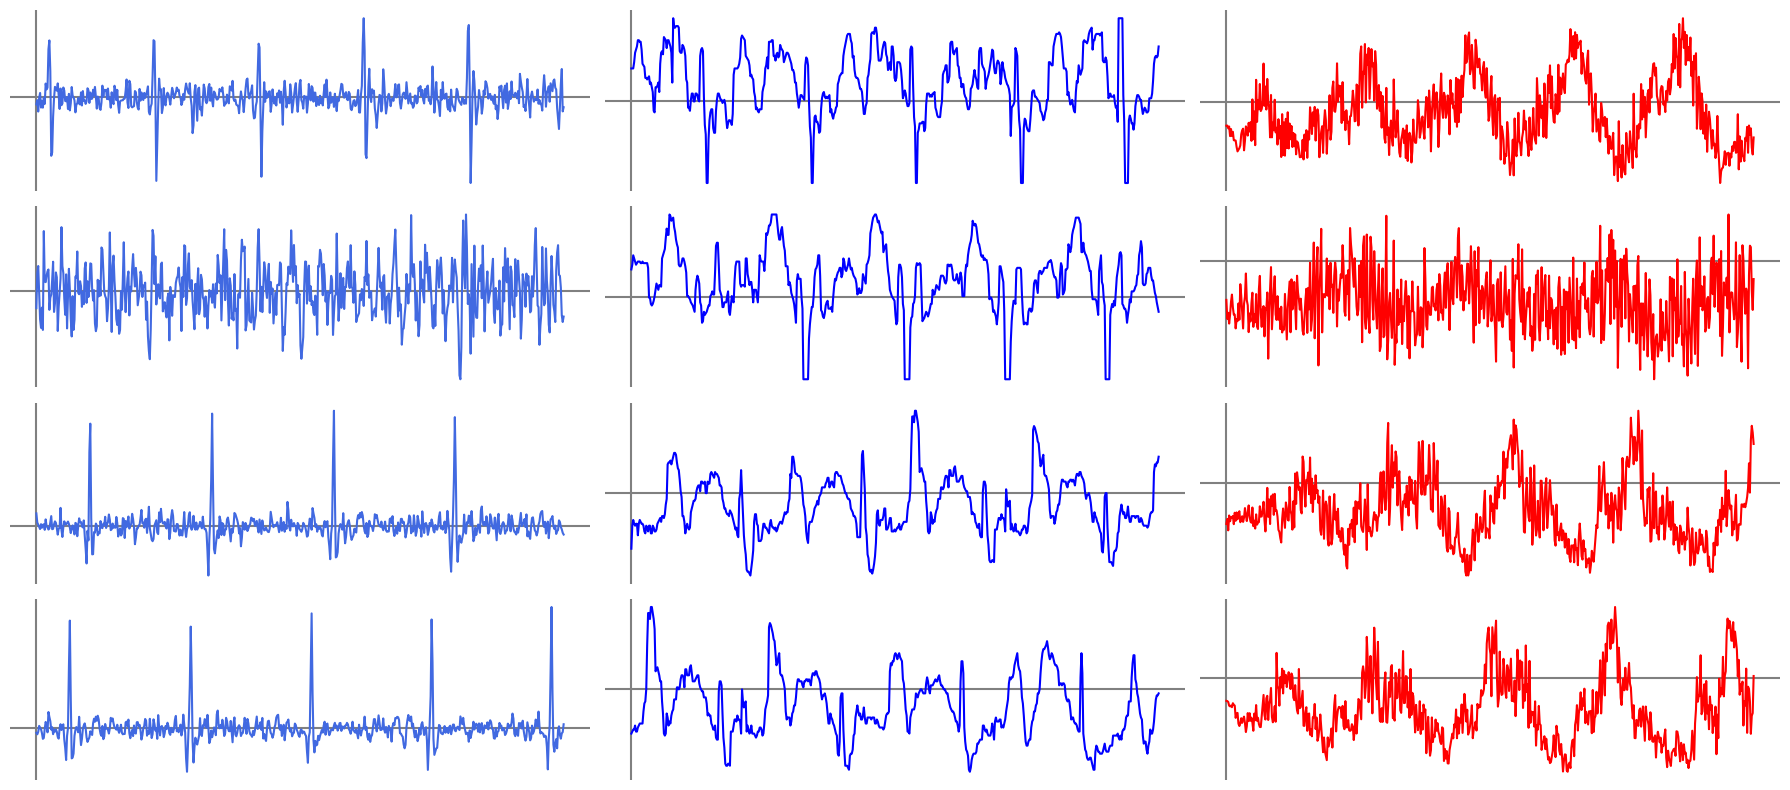

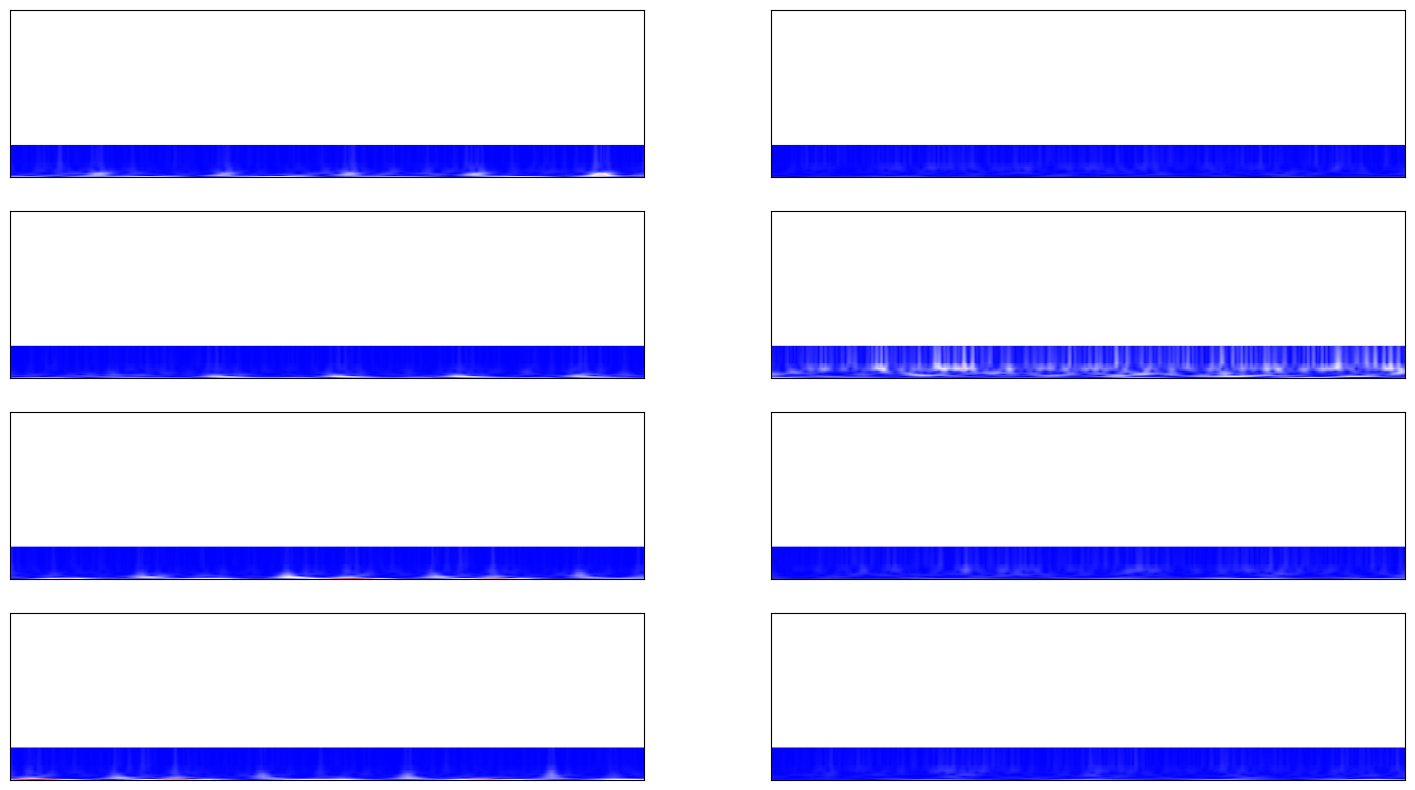

In [6]:
model_path = Path("./WaveNet_beat/models/model_2.h5")
WaveNet = tf.keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)


save_dir_plots = './WaveNet_beat/plots'
os.makedirs(save_dir_plots, exist_ok=True)

# Show some random generated
# Randomly select 4 ECG samples and their corresponding real Doppler from the dataset
random_indices = np.random.choice(len(ECG_test), 4, replace=False)
selected_ecgs = ECG_test[random_indices]
selected_real_dopplers = ENV_test[random_indices]
# Generate Doppler using the model
generated_dopplers = WaveNet.predict(selected_ecgs).squeeze(-1)
# Plot the selected ECGs, real Dopplers, and their corresponding generated Doppler signals
modules.plot_ecg_doppler_pairs(selected_ecgs, selected_real_dopplers, generated_dopplers)
modules.plot_scalogram(selected_real_dopplers, generated_dopplers)

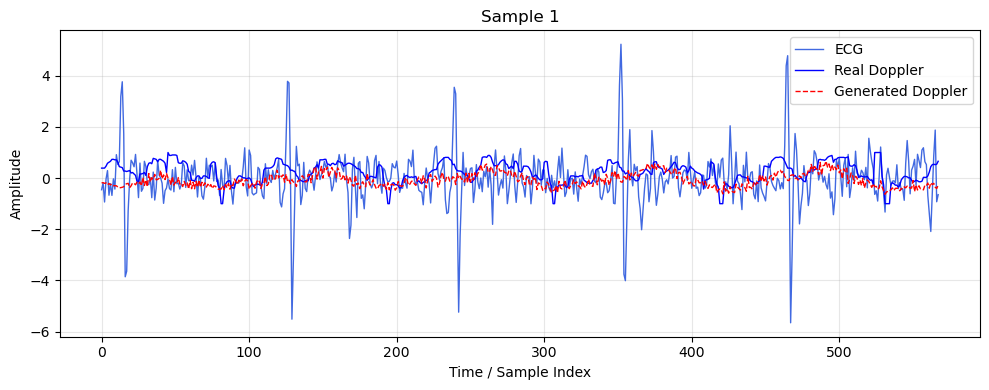

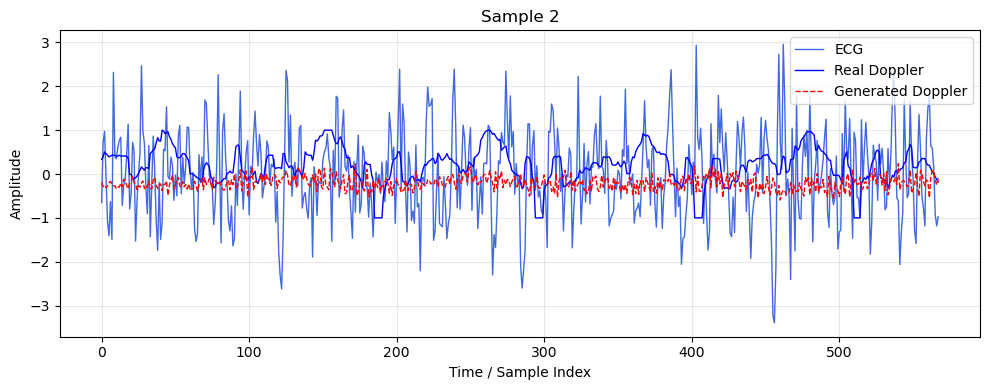

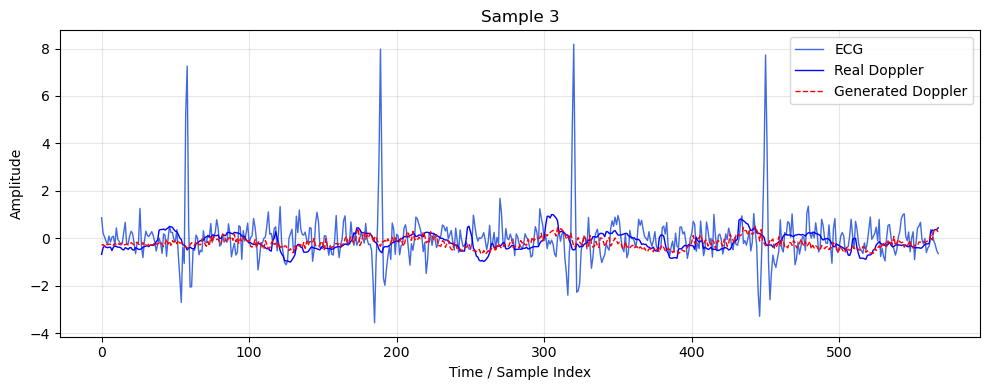

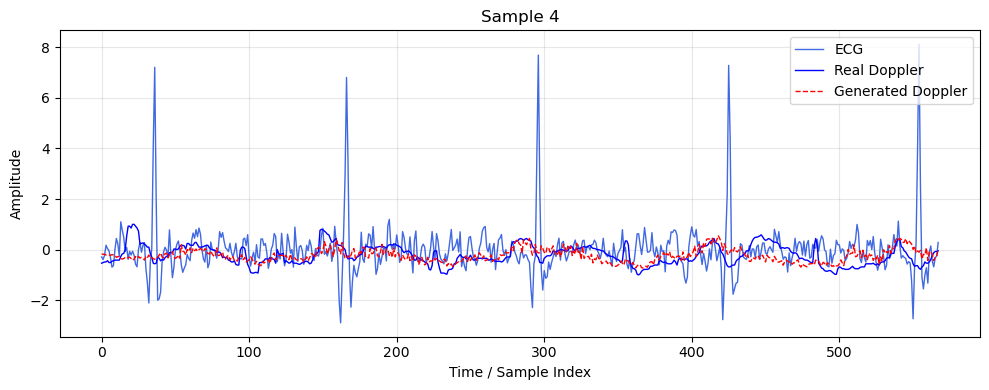

In [7]:
modules.plot_ecg_doppler_overlay(selected_ecgs, selected_real_dopplers, generated_dopplers)

In [8]:
def plot_doppler_overlay(real_dopplers, generated_dopplers, labels=None, colors=None):
    labels = labels or {'real': 'Real Doppler', 'gen': 'Generated Doppler'}
    colors = colors or {'real': 'blue', 'gen': 'red'}

    for i, (real_dop, gen_dop) in enumerate(zip(real_dopplers, generated_dopplers), start=1):
        plt.figure(figsize=(10, 4))
        plt.plot(real_dop, label=labels['real'], color=colors['real'], linewidth=1)
        plt.plot(gen_dop, label=labels['gen'], color=colors['gen'], linewidth=1, linestyle='--')

        plt.title(f'Sample {i}')
        plt.legend(loc='upper right')
        plt.xlabel('Time / Sample Index')
        plt.ylabel('Amplitude')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'WaveNet_beat/plots/signals_test_{i}.jpg')
        plt.show()

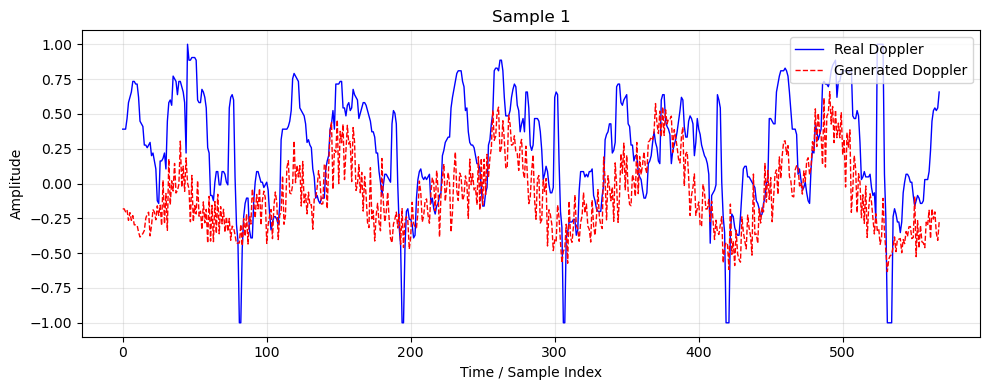

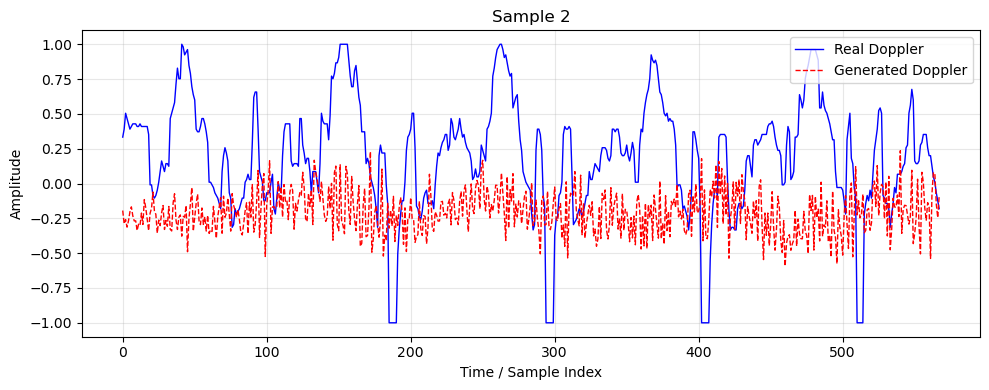

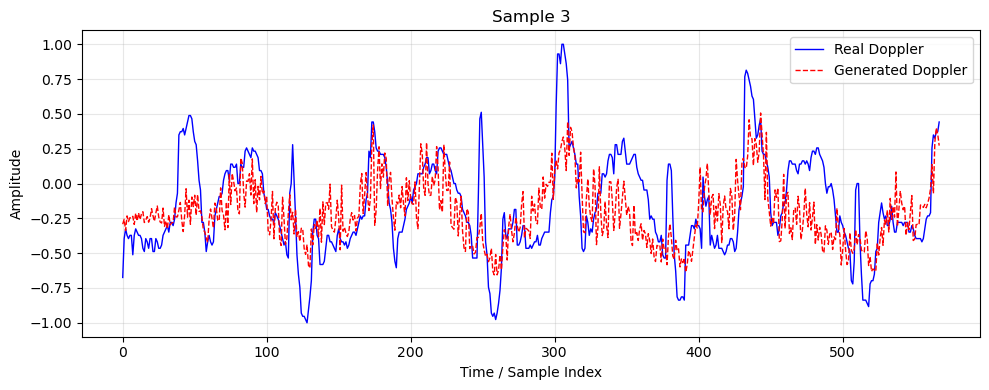

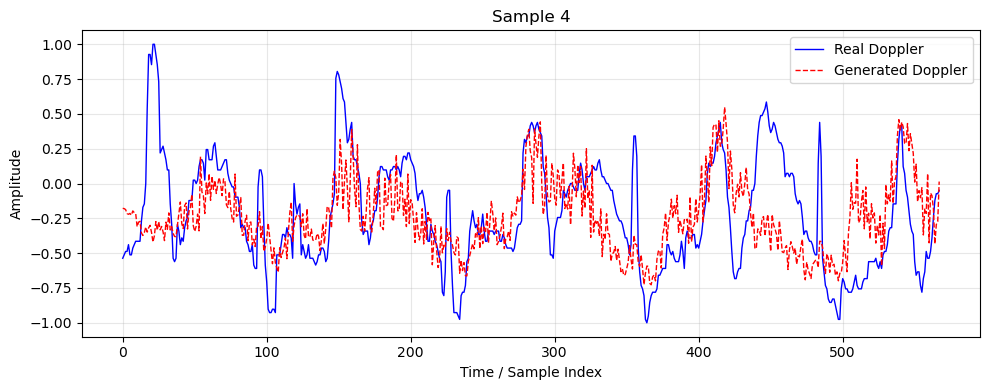

In [9]:
plot_doppler_overlay(selected_real_dopplers, generated_dopplers)